# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.optimize import minimize

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4290.894985,1.0001,-131.886217,2105.96,1974.073783
OMUSDT,526.319895,1866.342146,0.4350,0.000000,1340.02,1340.020000
BTCUSDT,601.021649,882.544641,0.2057,3.537078,281.52,285.057078
JASMYUSDT,387.458505,627.108047,0.1461,0.000000,239.65,239.650000
SOLUSDT,281.200518,427.665239,0.0997,0.000000,146.46,146.460000
ETHUSDT,250.747339,276.894714,0.0645,0.000000,26.15,26.150000
TRXUSDT,76.868953,155.615505,0.0363,-10.723889,78.75,68.026111
BBUSDT,60.176053,53.444839,0.0125,-39.733101,-6.73,-46.463101
BNBUSDT,1.142121,1.279849,0.0003,-10.606040,0.14,-10.466040
PEPEUSDT,0.000004,0.000006,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [19]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

quantities_tickers=list(quantities.columns)

In [20]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [21]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [22]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-12-02    1418.524583
2024-12-03    1806.096259
2024-12-04    1729.714053
2024-12-05    1990.847138
2024-12-06    1981.149715
Name: Total, Length: 75, dtype: float64

In [23]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

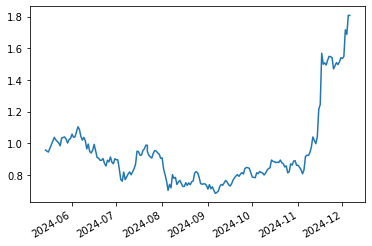

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT', 'BTCUSDT',
       'CRVUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MANAUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.9886
AAVEUSDT,0.0114
ARUSDT,0.0000
FILUSDT,0.0000
SOLUSDT,0.0000
MKRUSDT,0.0000
ETCUSDT,0.0000
DYDXUSDT,0.0000
LINKUSDT,0.0000
GALAUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.327588
BTCUSDT,0.300000
TRXUSDT,0.112470
PEPEUSDT,0.070369
XLMUSDT,0.058365
SUIUSDT,0.049168
JASMYUSDT,0.030437
XRPUSDT,0.029033
BNBUSDT,0.022569


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.351763
OMUSDT,0.337404
TRXUSDT,0.261019
PEPEUSDT,0.039759
JASMYUSDT,0.010054


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1866.342146,0.434954,0.337404,0.097550
BTCUSDT,882.544641,0.205678,0.351763,-0.146085
JASMYUSDT,627.108047,0.146148,0.010054,0.136095
SOLUSDT,427.665239,0.099668,0.000000,0.000000
ETHUSDT,276.894714,0.064531,0.000000,0.000000
TRXUSDT,155.615505,0.036266,0.261019,-0.224753
BBUSDT,53.444839,0.012455,0.000000,0.000000
BNBUSDT,1.279849,0.000298,0.000000,0.000000
PEPEUSDT,0.000006,0.000000,0.039759,-0.039759


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1866.342146,0.434954,0.327588,0.107366
BTCUSDT,882.544641,0.205678,0.300000,-0.094322
JASMYUSDT,627.108047,0.146148,0.030437,0.115712
SOLUSDT,427.665239,0.099668,0.000000,0.000000
ETHUSDT,276.894714,0.064531,0.000000,0.000000
TRXUSDT,155.615505,0.036266,0.112470,-0.076204
BBUSDT,53.444839,0.012455,0.000000,0.000000
BNBUSDT,1.279849,0.000298,0.022569,-0.022271
PEPEUSDT,0.000006,0.000000,0.070369,-0.070369
XLMUSDT,0.000000,0.000000,0.058365,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

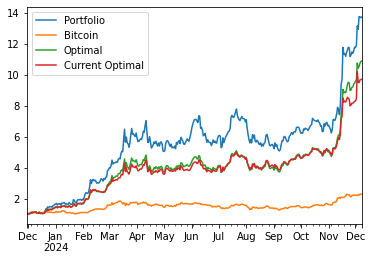

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

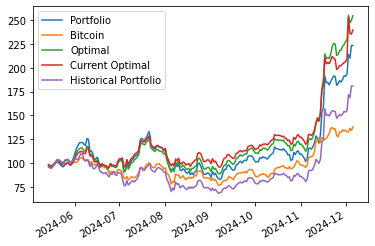

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-27,186.430550,132.783198,218.039983,202.393164,150.943684
2024-11-28,185.039275,132.479326,218.312093,202.084351,149.674755
2024-11-29,187.539507,134.971167,222.666593,203.988711,151.414174
2024-11-30,191.476491,133.506331,224.214599,205.243698,154.042164
2024-12-01,191.077542,134.578273,227.478553,206.151898,153.524639
2024-12-02,193.393646,132.703379,229.222200,209.673248,154.867822
2024-12-03,213.872173,132.715937,255.103237,253.307192,171.684779
2024-12-04,210.188887,136.453406,247.170995,235.996499,168.792541
2024-12-05,223.469147,134.162033,249.933224,235.377257,180.882889
2024-12-06,223.334482,137.975577,254.581176,239.670594,180.754476


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.5846
 dtype: float64,
 0.5853540604988393)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.635223
 dtype: float64,
 0.6352230310946546)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.705042
Bitcoin            0.434787
Optimal            0.585354
Current Optimal    0.577848
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4588418822913971

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.040491,0.022569,0.003133,0.008925,0.000338,0.008587
BTCUSDT,0.389665,0.300000,0.034269,0.149822,0.049655,0.100168
JASMYUSDT,0.097208,0.030437,0.006343,0.024713,0.003367,0.021345
OMUSDT,17.695453,0.327588,0.895558,0.619128,0.511206,0.107922
PEPEUSDT,0.446373,0.070369,0.025677,0.079266,0.023322,0.055944
SUIUSDT,0.136257,0.049168,0.009214,0.034001,0.006394,0.027608
TRXUSDT,0.151148,0.112470,0.013099,0.041737,0.016867,0.024870
XLMUSDT,0.106574,0.058365,0.008196,0.028180,0.005764,0.022417
XRPUSDT,0.061770,0.029033,0.004512,0.014228,0.001043,0.013185


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.921698,0.337404,0.529762,0.564536,0.446094,0.118443
BTCUSDT,0.168348,0.351763,0.218834,0.155784,0.073269,0.082515
JASMYUSDT,0.007029,0.010054,0.007188,0.009504,0.000408,0.009096
TRXUSDT,0.257597,0.261019,0.218206,0.235083,0.178498,0.056586
PEPEUSDT,0.022062,0.039759,0.026011,0.035092,0.006682,0.028410


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.174645,0.43,0.651284,0.637379,0.513663,0.123716
BTCUSDT,0.100502,0.21,0.126025,0.084948,0.018513,0.066435
JASMYUSDT,0.104868,0.15,0.103444,0.154718,0.064385,0.090334
SOLUSDT,0.036877,0.10,0.055555,0.070545,0.010138,0.060406
ETHUSDT,0.012052,0.06,0.029244,0.027722,0.002635,0.025087
TRXUSDT,0.039476,0.04,0.032257,0.014426,0.002972,0.011455
BBUSDT,-0.004603,0.01,0.002191,0.010261,0.000393,0.009868


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04770663495935977, -0.06837667644089787)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048035312236236284, -0.06776836918524114)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.031897
BTCUSDT     -0.001960
JASMYUSDT   -0.008330
SOLUSDT     -0.003077
ETHUSDT     -0.001657
TRXUSDT     -0.000573
BBUSDT      -0.001246
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048740
Name: 2024-07-22 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.038108
BTCUSDT     -0.007166
JASMYUSDT   -0.012251
SOLUSDT     -0.006599
ETHUSDT     -0.002236
TRXUSDT     -0.000657
BBUSDT      -0.000752
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067768
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06065206918955594, -0.07773918333262217)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06581929439409574, -0.08436213738619693)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0531090116091619, -0.06887086521404327)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06143537825447991, -0.07876424679635911)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.038784
BTCUSDT     -0.005369
JASMYUSDT   -0.008903
SOLUSDT     -0.004706
ETHUSDT     -0.001843
TRXUSDT     -0.000370
BBUSDT      -0.000729
Portfolio   -0.060704
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0527362154562691, -0.06820724761316714)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05977778633548034, -0.07566779802079755)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.038308
BTCUSDT     -0.005547
JASMYUSDT   -0.009251
SOLUSDT     -0.004309
ETHUSDT     -0.001775
TRXUSDT     -0.000743
BBUSDT      -0.000660
Portfolio   -0.060593
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05306177467324253, -0.06934734909743427)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.062118037085305354, -0.08011926770324293)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.039659
BTCUSDT     -0.005467
JASMYUSDT   -0.008726
SOLUSDT     -0.004521
ETHUSDT     -0.001756
TRXUSDT     -0.000820
BBUSDT      -0.000700
Portfolio   -0.061649
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0988807726905112, -0.1366571674953857)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10475238336740036, -0.15151265120784593)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.093349
BTCUSDT     -0.002596
JASMYUSDT   -0.009743
SOLUSDT     -0.000636
ETHUSDT     -0.000445
TRXUSDT     -0.000106
BBUSDT      -0.000163
Portfolio   -0.107038
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06216890488231695, -0.0774499820485644)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06663725916925715, -0.0829749146138819)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.042732
BTCUSDT     -0.005452
JASMYUSDT   -0.010934
SOLUSDT     -0.004778
ETHUSDT     -0.001919
TRXUSDT     -0.000902
BBUSDT      -0.000684
Portfolio   -0.067402
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.050910,-0.084759,-0.072742,-0.024887
2024-01-15,-0.050910,-0.084760,-0.073933,0.014071
2024-01-16,-0.050910,-0.084519,-0.072022,0.038255
2024-01-17,-0.050910,-0.086004,-0.071035,-0.024640
2024-01-18,-0.050910,-0.088441,-0.075898,-0.035955
...,...,...,...,...
2024-12-04,-0.046302,-0.112909,-0.084420,-0.031094
2024-12-05,-0.046302,-0.113127,-0.085151,0.011175
2024-12-06,-0.046302,-0.110323,-0.079248,0.018597
2024-12-07,-0.046302,-0.110129,-0.085828,0.012330


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034747,-0.084721,-0.076136,-0.017896
2024-05-29,-0.034747,-0.082047,-0.075357,-0.008623
2024-05-30,-0.034747,-0.072415,-0.066717,0.041564
2024-05-31,-0.034747,-0.073492,-0.065324,0.039579
2024-06-01,-0.034747,-0.076997,-0.068034,0.052811
...,...,...,...,...
2024-12-04,-0.044527,-0.075985,-0.066754,-0.017222
2024-12-05,-0.044527,-0.080874,-0.067969,0.063183
2024-12-06,-0.044527,-0.081222,-0.067321,-0.000603
2024-12-07,-0.044527,-0.081842,-0.070674,-0.004186


<AxesSubplot:>

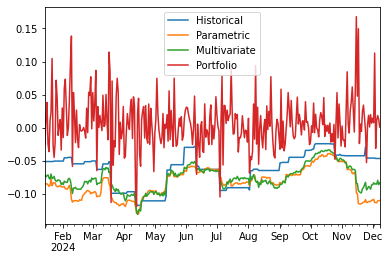

In [79]:
var_data.plot()

<AxesSubplot:>

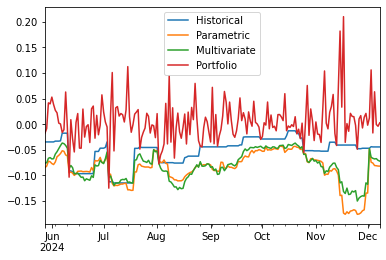

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024242,0.012121,0.012121
Kupiec Stat,5.645706,14.155382,14.155382
P-value,0.017498,0.000168,0.000168


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.061538,0.015385,0.015385
Kupiec Stat,0.510784,6.671087,6.671087
P-value,0.4748,0.009799,0.009799


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77330208, 0.07614374, 0.05558505, 0.05504609, 0.03992304])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014899
ADAUSDT     0.014957
ALGOUSDT    0.016992
APTUSDT     0.015548
ARBUSDT     0.016442
              ...   
WBTCUSDT    0.009434
WLDUSDT     0.021476
XLMUSDT     0.011973
XRPUSDT     0.010407
XTZUSDT     0.015819
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

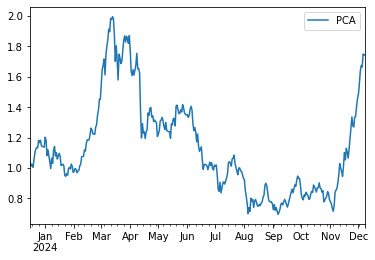

In [85]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

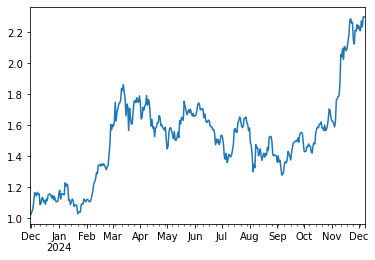

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.403334
EGLDUSDT     0.416611
WBETHUSDT    0.417628
ETHUSDT      0.417800
               ...   
FLOKIUSDT    1.116466
BONKUSDT     1.127139
WLDUSDT      1.127641
PEPEUSDT     1.164791
OMUSDT       1.526413
Length: 65, dtype: float64

<AxesSubplot:>

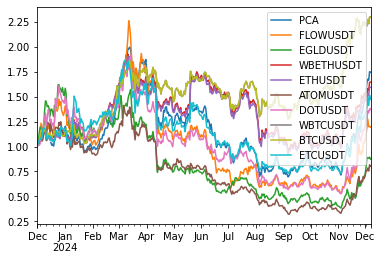

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

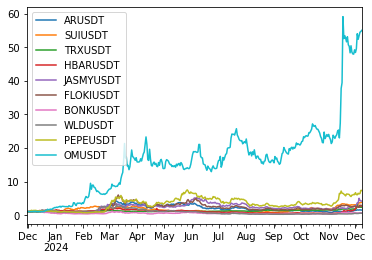

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52666499, 0.15214939, 0.13661173, 0.10535488, 0.07921901])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.101439
BTCUSDT      0.062920
JASMYUSDT    0.165077
SOLUSDT      0.102871
ETHUSDT      0.083655
TRXUSDT      0.040516
BBUSDT       0.212699
BNBUSDT      0.067122
PEPEUSDT     0.163702
Name: PC1, dtype: float64

<AxesSubplot:>

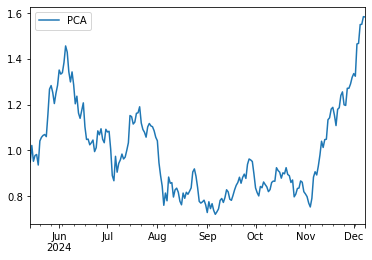

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

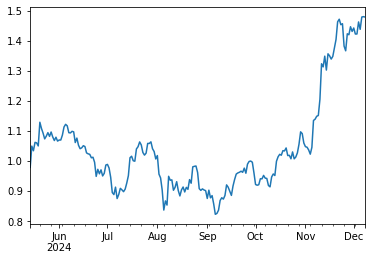

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.380732
ETHUSDT      0.399729
BNBUSDT      0.408996
BTCUSDT      0.414934
JASMYUSDT    0.640590
PEPEUSDT     0.680392
BBUSDT       0.705721
OMUSDT       0.863788
TRXUSDT      0.881687
dtype: float64

<AxesSubplot:>

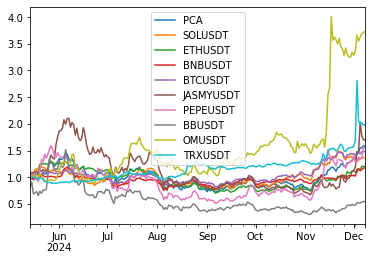

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.905910
BBUSDT       1.515550
JASMYUSDT    1.213028
SOLUSDT      1.139597
BTCUSDT      1.000000
ETHUSDT      0.950034
OMUSDT       0.872218
BNBUSDT      0.653282
TRXUSDT      0.236969
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.747601
BTCUSDT      1.000000
ETHUSDT      0.943681
SOLUSDT      0.930799
BNBUSDT      0.789979
BBUSDT       0.589654
OMUSDT      -0.236363
TRXUSDT     -0.502795
JASMYUSDT   -0.539487
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [98]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [99]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.811359
BBUSDT,0.350748
ETHUSDT,0.241184
JASMYUSDT,0.138630
OMUSDT,0.075740
TRXUSDT,0.033173
PEPEUSDT,-0.012619
BNBUSDT,-0.047366
SOLUSDT,-0.480261


### Regression to PCA

In [100]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.24073050803590723

In [101]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.203719
BNBUSDT      1.059045
PCA          1.000000
ETHUSDT      0.918643
SOLUSDT      0.753647
JASMYUSDT    0.386722
PEPEUSDT     0.361498
BBUSDT       0.329579
OMUSDT       0.210049
TRXUSDT      0.144884
dtype: float64

In [102]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

PCA          1.000000
BTCUSDT      0.907353
SOLUSDT      0.444664
BNBUSDT      0.420264
BBUSDT       0.377212
ETHUSDT      0.272081
OMUSDT       0.229016
TRXUSDT      0.055156
PEPEUSDT     0.049983
JASMYUSDT    0.032668
dtype: float64

### Correlation Matrix

In [103]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.296834,0.155663,0.353927,0.227220,0.131092,0.267887,0.206553,0.168724
BTCUSDT,0.296834,1.000000,0.472596,0.703915,0.789991,0.152427,0.553063,0.595689,0.652321
JASMYUSDT,0.155663,0.472596,1.000000,0.455296,0.460722,0.234357,0.542675,0.438970,0.368534
SOLUSDT,0.353927,0.703915,0.455296,1.000000,0.652565,0.175369,0.547154,0.508527,0.540521
ETHUSDT,0.227220,0.789991,0.460722,0.652565,1.000000,0.124963,0.601033,0.583957,0.639519
TRXUSDT,0.131092,0.152427,0.234357,0.175369,0.124963,1.000000,0.131263,0.297354,0.095115
BBUSDT,0.267887,0.553063,0.542675,0.547154,0.601033,0.131263,1.000000,0.578041,0.470072
BNBUSDT,0.206553,0.595689,0.438970,0.508527,0.583957,0.297354,0.578041,1.000000,0.418951
PEPEUSDT,0.168724,0.652321,0.368534,0.540521,0.639519,0.095115,0.470072,0.418951,1.000000


In [104]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,-0.157663,0.438155,0.262177,-0.459733,0.743450,0.353747,0.387305,-0.338964
BTCUSDT,-0.157663,1.000000,-0.097534,0.650885,0.614064,-0.058273,0.326355,0.447447,0.631472
JASMYUSDT,0.438155,-0.097534,1.000000,0.504757,-0.219411,0.440324,0.156948,0.238357,-0.180613
SOLUSDT,0.262177,0.650885,0.504757,1.000000,0.216949,0.389736,0.441589,0.572326,0.459984
ETHUSDT,-0.459733,0.614064,-0.219411,0.216949,1.000000,-0.254169,0.301774,0.205354,0.405819
TRXUSDT,0.743450,-0.058273,0.440324,0.389736,-0.254169,1.000000,0.519906,0.767533,-0.180241
BBUSDT,0.353747,0.326355,0.156948,0.441589,0.301774,0.519906,1.000000,0.629637,-0.020571
BNBUSDT,0.387305,0.447447,0.238357,0.572326,0.205354,0.767533,0.629637,1.000000,0.325728
PEPEUSDT,-0.338964,0.631472,-0.180613,0.459984,0.405819,-0.180241,-0.020571,0.325728,1.000000


## Sliding window optimization

In [105]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.621968,0.000000,0.000000,0.000000,0.00000,0.000000,0.378032
2024-06-10,0.625939,0.000000,0.150852,0.000000,0.000000,0.223209,0.00000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000
2024-07-08,0.182528,0.000000,0.000000,0.000000,0.000000,0.817472,0.00000,0.000000,0.000000
2024-07-22,0.133242,0.414563,0.000000,0.112009,0.000000,0.340186,0.00000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926694,0.00000,0.073306,0.000000
2024-09-02,0.435138,0.000000,0.000000,0.000000,0.000000,0.564862,0.00000,0.000000,0.000000
2024-09-16,0.287440,0.000000,0.000000,0.000000,0.000000,0.000000,0.71256,0.000000,0.000000
2024-09-30,0.176666,0.000000,0.000000,0.000000,0.165949,0.527049,0.00000,0.000000,0.130336


In [106]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-05-02,0.013254,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.986746,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-06-01,0.013254,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-07-01,0.013254,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.986746,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-07-31,0.041751,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.610426,0.0
2024-08-30,0.241600,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.758400,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-09-29,0.013254,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.053971,0.0
2024-10-29,0.013254,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.593994,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-11-28,0.013254,0.0,0.02301,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.126338,0.270645,0.0
2024-12-08,0.052147,0.0,0.00000,0.0,0.071659,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.025397,0.000000,0.000000,0.0


In [107]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

OMUSDT       0.255306
FTMUSDT      0.163282
DOGEUSDT     0.157341
FLOKIUSDT    0.127055
SUIUSDT      0.089848
               ...   
HBARUSDT     0.000000
ICPUSDT      0.000000
IMXUSDT      0.000000
INJUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-12-08 00:00:00, Length: 64, dtype: float64

<AxesSubplot:>

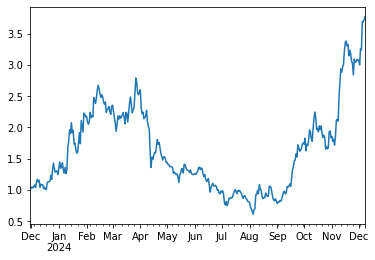

In [108]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()